# **CSE4020 Machine Learning J Component**
## **Project Title: Stock Market Prediction using Machine Learning**
### **Team Members:**
1.   T Rahul Reddy (19BCE1778)
2.   Bandaru Kedaarnath (19BCE1370)

**Aim:**  
1.   For Review 2 we have successfully incorporated Random Forest Algorithm to build a classification model that helped us to predict the trend of the stock based on its Technical Indicators.
2.   For Review 3 we have built a Stacked LSTM Model that helped us to forecast the stock open prices based on Time Series Data.


## **Stock Trend Prediction using Random Forest**

**Installing Dependencies**

In [1]:
!pip install yfinance
!pip install plotly

#### Importing Libraries

In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import accuracy_score, classification_report

#### Fetching Stock Data from Yahoo Finance

In [3]:
#fetching the last 10 years data with interval of 1 day
stock_symbol = "AAPL"
price_data  = yf.download(tickers=stock_symbol,period='10y',interval='1d')
price_data.reset_index(inplace = True) # resetting index

[*********************100%***********************]  1 of 1 completed


In [4]:
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200


In [5]:
price_data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
2512,2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200
2513,2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2514,2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500
2515,2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200
2516,2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300


#### **Computing Technical Indicators**
**1. Relative Strength Index (RSI):** RSI is a popular momentum indicator that determines whether the stock is overbought or oversold.
RSI ranges from 0 to 100:
*   RSI > 70 indicates that the stock is overbought
*   RSI < 30 indicate the stock is oversold.

<br>RSI Formula is denoted as:

$$\begin{align}
\ RSI = 100 - \frac{100}{1+RS}
\end{align}$$

In [6]:
# calculating the change in price to further compute RSI
price_data['change_in_price'] = price_data['Close'].diff()
#The diff() method will calculate the difference from one row to the next.
price_data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714


In [7]:
# Calculate the 14 day RSI
n = 14
up_df, down_df = price_data[['change_in_price']].copy(), price_data[['change_in_price']].copy()

# For up days, if the change is less than 0 set to 0.
up_df.loc['change_in_price'] = up_df.loc[(up_df['change_in_price'] < 0), 'change_in_price'] = 0
#basically the above col will only contain positive values i.e. it will only contains the rows where the price moved up, if it didn't move up it will be 0

# For down days, if the change is greater than 0 set to 0.
down_df.loc['change_in_price'] = down_df.loc[(down_df['change_in_price'] > 0), 'change_in_price'] = 0
#basically the above col will only contain negative values i.e. it will only contains the rows where the price moved down, if it didn't move down it will be 0

# We need change in price to be absolute as RSI formula expects only +ve values
down_df['change_in_price'] = down_df['change_in_price'].abs()

# Calculate the EWMA (Exponential Weighted Moving Average), meaning older values are given less weight compared to newer values.
#we do this so that we put more emphasis on more recent data but also not completely removing the older data
#x.ewm() performs the EWMA calculation
ewma_up = up_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())
ewma_down = down_df['change_in_price'].transform(lambda x: x.ewm(span = n).mean())

# Calculate the Relative Strength
relative_strength = ewma_up / ewma_down

# Calculate the Relative Strength Index
relative_strength_index = 100.0 - (100.0 / (1.0 + relative_strength))

# Add the info to the data frame.
price_data['down_days'] = down_df['change_in_price']
price_data['up_days'] = up_df['change_in_price']
price_data['RSI'] = relative_strength_index

# Display the head.
price_data.head(10)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386
5,2011-12-12,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442
6,2011-12-13,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288
7,2011-12-14,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243
8,2011-12-15,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996
9,2011-12-16,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082


In [8]:
price_data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI
2507,2021-11-19,157.649994,161.020004,156.529999,160.550003,160.550003,117305600,2.680008,0.000000,2.680008,84.677884
2508,2021-11-22,161.679993,165.699997,161.000000,161.020004,161.020004,117467900,0.470001,0.000000,0.470001,85.269679
2509,2021-11-23,161.119995,161.800003,159.059998,161.410004,161.410004,96041900,0.389999,0.000000,0.389999,85.794978
2510,2021-11-24,160.750000,162.139999,159.639999,161.940002,161.940002,69463600,0.529999,0.000000,0.529999,86.547234
2511,2021-11-26,159.570007,160.449997,156.360001,156.809998,156.809998,76959800,-5.130005,5.130005,0.000000,54.382806
2512,2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200,3.430008,0.000000,3.430008,64.547508
2513,2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100,5.059998,0.000000,5.059998,74.296528
2514,2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500,-0.529999,0.529999,0.000000,71.906757
2515,2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200,-1.010010,1.010010,0.000000,67.156935
2516,2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300,-1.919998,1.919998,0.000000,58.658111


**2. Stochastic Oscillator:** It helps us to follow the speed or the momentum of the price. As a rule, momentum changes before the price changes. It measures the level of the closing price relative to the low-high range over a period of time.<br>
Stochastic Oscillator Formula is denoted as:

$$\begin{align}
\ K = 100 \ast  \frac{(C-L_{14})}{(H_{14}-L_{14})}
\end{align}$$

$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

In [9]:
# Calculate the Stochastic Oscillator
n = 14
low_14, high_14 = price_data[['Low']].copy(), price_data[['High']].copy()

# apply the rolling function and grab the Min and Max
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate the Stochastic Oscillator.
k_percent = 100 * ((price_data['Close'] - low_14) / (high_14 - low_14))

# Add the info to the data frame.
price_data['low_14'] = low_14
price_data['high_14'] = high_14
price_data['k_percent'] = k_percent

# Display the head.
price_data.head(15)
#as our windows is 14 days so first 14 rows it will be null

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000,NaN,NaN,NaN
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000,NaN,NaN,NaN
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421,NaN,NaN,NaN
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386,NaN,NaN,NaN
5,2011-12-12,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442,NaN,NaN,NaN
6,2011-12-13,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288,NaN,NaN,NaN
7,2011-12-14,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243,NaN,NaN,NaN
8,2011-12-15,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996,NaN,NaN,NaN
9,2011-12-16,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082,NaN,NaN,NaN


In [10]:
price_data.tail(10)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent
2507,2021-11-19,157.649994,161.020004,156.529999,160.550003,160.550003,117305600,2.680008,0.000000,2.680008,84.677884,147.479996,161.020004,96.528797
2508,2021-11-22,161.679993,165.699997,161.000000,161.020004,161.020004,117467900,0.470001,0.000000,0.470001,85.269679,147.479996,165.699997,74.313983
2509,2021-11-23,161.119995,161.800003,159.059998,161.410004,161.410004,96041900,0.389999,0.000000,0.389999,85.794978,147.479996,165.699997,76.454484
2510,2021-11-24,160.750000,162.139999,159.639999,161.940002,161.940002,69463600,0.529999,0.000000,0.529999,86.547234,147.479996,165.699997,79.363369
2511,2021-11-26,159.570007,160.449997,156.360001,156.809998,156.809998,76959800,-5.130005,5.130005,0.000000,54.382806,147.479996,165.699997,51.207471
2512,2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200,3.430008,0.000000,3.430008,64.547508,147.479996,165.699997,70.032980
2513,2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100,5.059998,0.000000,5.059998,74.296528,147.479996,165.699997,97.804644
2514,2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500,-0.529999,0.529999,0.000000,71.906757,147.479996,170.300003,75.766884
2515,2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200,-1.010010,1.010010,0.000000,67.156935,147.479996,170.300003,71.340901
2516,2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300,-1.919998,1.919998,0.000000,58.658111,149.339996,170.300003,59.637385


**3. William's R% :** Williams R% ranges from -100 to 0. When its value is above -20, it indicates a sell signal and when its value is below -80, it indicates a buy signal.

William's R% Formula is denoted as:

$$\begin{align}
\ R = \frac{(H_{14}-C)}{(H_{14}-L_{14})} * - 100
\end{align}$$


$
\begin{align}
\ C = \text{Current Closing Price}
\end{align}
$

$
\begin{align}
\ L_{14} = \text{Lowest Low over the past 14 days}
\end{align}
$

$
\begin{align}
\ H_{14} = \text{Highest High over the past 14 days}
\end{align}
$

In [11]:
# Calculate the Williams %R
n = 14
low_14, high_14 = price_data[['Low']].copy(), price_data[['High']].copy()

# apply the rolling function and grab the Min and Max
low_14 = low_14['Low'].transform(lambda x: x.rolling(window = n).min())
high_14 = high_14['High'].transform(lambda x: x.rolling(window = n).max())

# Calculate William %R indicator.
r_percent = ((high_14 - price_data['Close']) / (high_14 - low_14)) * - 100

# Add the info to the data frame.
price_data['r_percent'] = r_percent

# Display the head.
price_data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000,NaN,NaN,NaN,NaN
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000,NaN,NaN,NaN,NaN
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421,NaN,NaN,NaN,NaN
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386,NaN,NaN,NaN,NaN
5,2011-12-12,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442,NaN,NaN,NaN,NaN
6,2011-12-13,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288,NaN,NaN,NaN,NaN
7,2011-12-14,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243,NaN,NaN,NaN,NaN
8,2011-12-15,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996,NaN,NaN,NaN,NaN
9,2011-12-16,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082,NaN,NaN,NaN,NaN


In [12]:
price_data.tail(15)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent
2502,2021-11-12,148.429993,150.399994,147.479996,149.990005,149.990005,63632600,2.120010,0.000000,2.120010,53.994608,146.410004,153.169998,52.958650,-47.041350
2503,2021-11-15,150.369995,151.880005,149.429993,150.000000,150.000000,59222800,0.009995,0.000000,0.009995,54.052236,146.410004,153.169998,53.106498,-46.893502
2504,2021-11-16,149.940002,151.490005,149.339996,151.000000,151.000000,59256200,1.000000,0.000000,1.000000,59.857457,146.410004,153.169998,67.899409,-32.100591
2505,2021-11-17,151.000000,155.000000,150.990005,153.490005,153.490005,88807000,2.490005,0.000000,2.490005,70.548318,146.410004,155.000000,82.421477,-17.578523
2506,2021-11-18,153.710007,158.669998,153.050003,157.869995,157.869995,137827700,4.379990,0.000000,4.379990,80.882245,147.479996,158.669998,92.850734,-7.149266
2507,2021-11-19,157.649994,161.020004,156.529999,160.550003,160.550003,117305600,2.680008,0.000000,2.680008,84.677884,147.479996,161.020004,96.528797,-3.471203
2508,2021-11-22,161.679993,165.699997,161.000000,161.020004,161.020004,117467900,0.470001,0.000000,0.470001,85.269679,147.479996,165.699997,74.313983,-25.686017
2509,2021-11-23,161.119995,161.800003,159.059998,161.410004,161.410004,96041900,0.389999,0.000000,0.389999,85.794978,147.479996,165.699997,76.454484,-23.545516
2510,2021-11-24,160.750000,162.139999,159.639999,161.940002,161.940002,69463600,0.529999,0.000000,0.529999,86.547234,147.479996,165.699997,79.363369,-20.636631
2511,2021-11-26,159.570007,160.449997,156.360001,156.809998,156.809998,76959800,-5.130005,5.130005,0.000000,54.382806,147.479996,165.699997,51.207471,-48.792529


**4. Moving Average Convergence Divergnece (MACD):** EMA stands for Exponential Moving Average. When the MACD goes below the SingalLine, it indicates a sell signal. When it goes above the SignalLine, it indicates a buy signal.

MACD & SignalLine Formula are denoted as:

$$\begin{align}
\ MACD = EMA_{12}(C) - EMA_{26}(C)
\end{align}$$$$\begin{align}
\ SignalLine = EMA_{9}(MACD)
\end{align}$$

$
\begin{align}
\ MACD = \text{Moving Average Convergence Divergence}
\end{align}
$

$
\begin{align}
\ C = \text{Closing Price}
\end{align}
$

$
\begin{align}
\ EMA_{n} = \text{n day Exponential Moving Average}
\end{align}
\\
$



In [13]:
# Calculate the MACD
ema_26 = price_data['Close'].transform(lambda x: x.ewm(span = 26).mean())
ema_12 = price_data['Close'].transform(lambda x: x.ewm(span = 12).mean())
macd = ema_12 - ema_26 #MACD=EMA12(C)−EMA26(C)

# Calculate the EMA
ema_9_macd = macd.ewm(span = 9).mean() #SignalLine=EMA9(MACD)

# Store the data in the data frame.
price_data['MACD'] = macd
price_data['MACD_EMA'] = ema_9_macd
#MACD_EMA is the signal line

# Print the head.
price_data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001651,-0.000917
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.004163,-0.002247
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421,NaN,NaN,NaN,NaN,-0.003179,-0.002563
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386,NaN,NaN,NaN,NaN,0.001629,-0.001316
5,2011-12-12,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442,NaN,NaN,NaN,NaN,0.001770,-0.000480
6,2011-12-13,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288,NaN,NaN,NaN,NaN,-0.003072,-0.001136
7,2011-12-14,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243,NaN,NaN,NaN,NaN,-0.020911,-0.005888
8,2011-12-15,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996,NaN,NaN,NaN,NaN,-0.035161,-0.012650
9,2011-12-16,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082,NaN,NaN,NaN,NaN,-0.040932,-0.018987


**5. Price Rate Of Change:** It measures the most recent change in price with respect to the price in n days ago.

Price Rate of Change Formula is denoted as:

$$\begin{align}
\\
\ PROC_{t} = \frac{C_{t} - C_{t-n}}{C_{t-n}}
\\
\end{align}$$

$
\begin{align}
\ PROC_{t} = \text{Price Rate of Change at time t}
\end{align}
$

$
\begin{align}
\ C_{t} = \text{Closing price at time t}
\end{align}
\\
$

In [14]:
# Calculate the Price Rate of Change
n = 9 #so first 9 rows are null

# Calculate the Rate of Change in the Price
price_data['Price_Rate_Of_Change'] = price_data['Close'].transform(lambda x: x.pct_change(periods = n))

# Print the first 30 rows
price_data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001651,-0.000917,NaN
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.004163,-0.002247,NaN
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421,NaN,NaN,NaN,NaN,-0.003179,-0.002563,NaN
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386,NaN,NaN,NaN,NaN,0.001629,-0.001316,NaN
5,2011-12-12,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442,NaN,NaN,NaN,NaN,0.001770,-0.000480,NaN
6,2011-12-13,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288,NaN,NaN,NaN,NaN,-0.003072,-0.001136,NaN
7,2011-12-14,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243,NaN,NaN,NaN,NaN,-0.020911,-0.005888,NaN
8,2011-12-15,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996,NaN,NaN,NaN,NaN,-0.035161,-0.012650,NaN
9,2011-12-16,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082,NaN,NaN,NaN,NaN,-0.040932,-0.018987,-0.030508


#### Visualising Technical Indicators

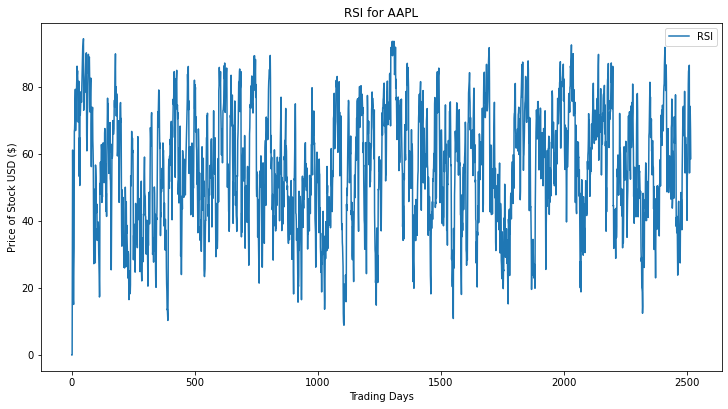

In [15]:
cols = ['RSI']
price_data[cols].plot(figsize=(12.2,6.4))
plt.title('RSI for '+stock_symbol)
plt.ylabel('Price of Stock USD ($)')
plt.xlabel('Trading Days')
plt.show()

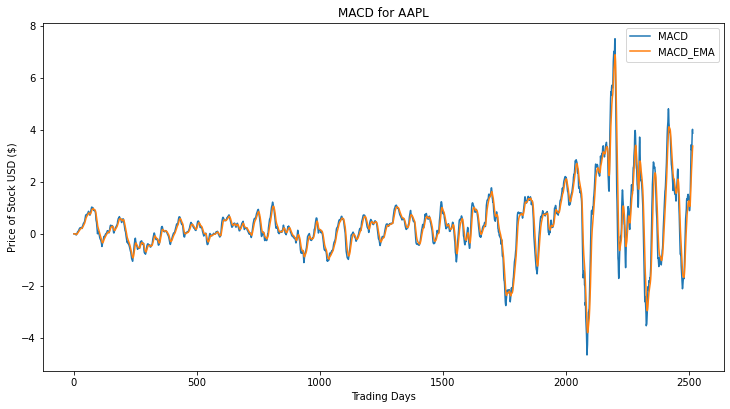

In [16]:
#MACD_EMA is the signal line
cols = ['MACD','MACD_EMA']
price_data[cols].plot(figsize=(12.2,6.4))
plt.title('MACD for '+stock_symbol)
plt.ylabel('Price of Stock USD ($)')
plt.xlabel('Trading Days')
plt.show()

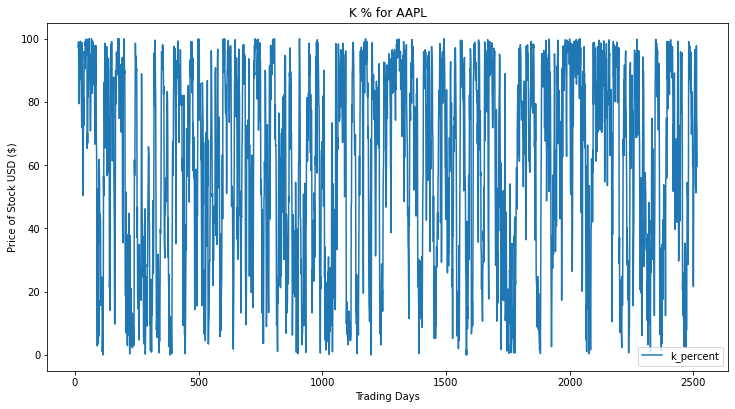

In [17]:
cols = ['k_percent']
price_data[cols].plot(figsize=(12.2,6.4))
plt.title('K % for '+stock_symbol)
plt.ylabel('Price of Stock USD ($)')
plt.xlabel('Trading Days')
plt.show()

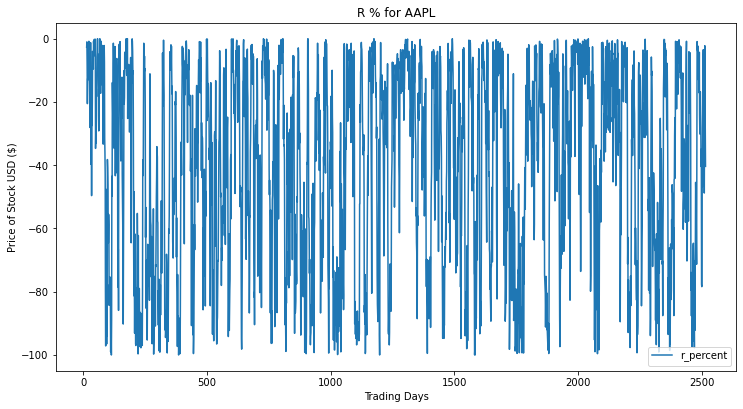

In [18]:
cols = ['r_percent']
price_data[cols].plot(figsize=(12.2,6.4))
plt.title('R % for '+stock_symbol)
plt.ylabel('Price of Stock USD ($)')
plt.xlabel('Trading Days')
plt.show()

**Computing Prediction Column: Our goal is to predict whether the next day is either a Down Day or an Up Day**

In [19]:
#We would like to build our output column, output = 1 if the closing price at time 't' is greater than 't-1' and 0 otherwise
#Basically if the today's closing price is greater than yesterday's closing price it would be 1.

close_groups = price_data['Close']

# Apply the lambda function which will return -1.0 for down day, 1.0 for up day and 0.0 for no change (flat day)
close_groups = close_groups.transform(lambda x : np.sign(x.diff()))

# add the data to the main dataframe
price_data['Prediction'] = close_groups

# To keep this as a binary classifier we are considering flat days as up days
price_data.loc[price_data['Prediction'] == 0.0] = 1.0

# print the head
price_data.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
0,2011-12-05 00:00:00,14.053214,14.157500,13.942500,14.036071,12.034038,357210000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN,NaN
1,2011-12-06 00:00:00,14.018214,14.093929,13.906429,13.962500,11.970961,283598000,-0.073571,0.073571,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.001651,-0.000917,NaN,-1.0
2,2011-12-07 00:00:00,13.926071,13.962143,13.812857,13.896071,11.914006,304746400,-0.066428,0.066428,0.000000,0.000000,NaN,NaN,NaN,NaN,-0.004163,-0.002247,NaN,-1.0
3,2011-12-08 00:00:00,13.980357,14.125000,13.936786,13.952143,11.962083,376356400,0.056071,0.000000,0.056071,33.197421,NaN,NaN,NaN,NaN,-0.003179,-0.002563,NaN,1.0
4,2011-12-09 00:00:00,14.030357,14.072857,13.965357,14.057857,12.052720,296993200,0.105714,0.000000,0.105714,61.210386,NaN,NaN,NaN,NaN,0.001629,-0.001316,NaN,1.0
5,2011-12-12 00:00:00,13.988571,14.067857,13.908929,13.994286,11.998210,301067200,-0.063571,0.063571,0.000000,47.414442,NaN,NaN,NaN,NaN,0.001770,-0.000480,NaN,-1.0
6,2011-12-13 00:00:00,14.035714,14.121429,13.825000,13.886071,11.905431,338928800,-0.108214,0.108214,0.000000,32.865288,NaN,NaN,NaN,NaN,-0.003072,-0.001136,NaN,-1.0
7,2011-12-14 00:00:00,13.810714,13.835000,13.488571,13.578214,11.641487,406887600,-0.307858,0.307858,0.000000,16.373243,NaN,NaN,NaN,NaN,-0.020911,-0.005888,NaN,-1.0
8,2011-12-15 00:00:00,13.690357,13.705000,13.511071,13.533571,11.603209,256200000,-0.044642,0.044642,0.000000,15.104996,NaN,NaN,NaN,NaN,-0.035161,-0.012650,NaN,-1.0
9,2011-12-16 00:00:00,13.584286,13.719643,13.556071,13.607857,11.666901,421478400,0.074286,0.000000,0.074286,26.096082,NaN,NaN,NaN,NaN,-0.040932,-0.018987,-0.030508,1.0


Removing Null Values from the above dataframe

In [20]:
print('Before removing Null Values there were {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
# Any row that has a `NaN` value will be dropped.
price_data = price_data.dropna()
print('After removing Null Values we have {} rows and {} columns'.format(price_data.shape[0], price_data.shape[1]))
price_data.head()

Before removing Null Values there were 2517 rows and 19 columns
After removing Null Values we have 2504 rows and 19 columns


,Date,Open,High,Low,Close,Adj Close,Volume,change_in_price,down_days,up_days,RSI,low_14,high_14,k_percent,r_percent,MACD,MACD_EMA,Price_Rate_Of_Change,Prediction
13,2011-12-22 00:00:00,14.178571,14.254643,14.146429,14.233929,12.203678,202358800,0.075000,0.000000,0.075000,70.480772,13.488571,14.254643,97.295978,-2.704022,0.025132,-0.007763,0.012525,1.0
14,2011-12-23 00:00:00,14.274643,14.413929,14.267500,14.404643,12.350039,269399200,0.170714,0.000000,0.170714,76.252645,13.488571,14.413929,98.996504,-1.003496,0.049973,0.004205,0.029323,1.0
15,2011-12-27 00:00:00,14.396429,14.610357,14.393571,14.518929,12.448026,265076000,0.114285,0.000000,0.114285,79.368713,13.488571,14.610357,91.849716,-8.150284,0.075125,0.018800,0.045575,1.0
16,2011-12-28 00:00:00,14.531786,14.580357,14.333571,14.380000,12.328909,228662000,-0.138928,0.138928,0.000000,67.031464,13.488571,14.610357,79.465143,-20.534857,0.084777,0.032299,0.059049,-1.0
17,2011-12-29 00:00:00,14.407143,14.487500,14.303929,14.468571,12.404846,215978000,0.088571,0.000000,0.088571,70.414414,13.488571,14.610357,87.360641,-12.639359,0.096713,0.045418,0.069087,1.0


#### Splitting the Data

In [21]:
X_Cols = price_data[['RSI','k_percent','r_percent','Price_Rate_Of_Change','MACD']]
Y_Cols = price_data['Prediction']
# Split X and y into training and test data
X_train, X_test, y_train, y_test = train_test_split(X_Cols.values, Y_Cols.values, random_state = 0)

In [22]:
X_train[:5]

array([[ 6.62157851e+01,  8.08791185e+01, -1.91208815e+01,
         4.80804638e-02,  5.05688274e-01],
       [ 7.76425089e+01,  9.63526281e+01, -3.64737189e+00,
         7.59268371e-02,  1.23628891e-01],
       [ 3.16491128e+01,  1.32890045e+01, -8.67109955e+01,
        -6.31389560e-02, -1.16450235e-01],
       [ 5.86270351e+01,  6.63705915e+01, -3.36294085e+01,
         6.25242819e-05,  5.60158763e-01],
       [ 5.44194426e+01,  6.83453365e+01, -3.16546635e+01,
         3.85416215e-02, -2.03732315e+00]])

In [23]:
y_train[:5]

array([-1.,  1., -1.,  1., -1.])

In [24]:
X_train.shape,y_train.shape

((1878, 5), (1878,))

In [25]:
X_test.shape,y_test.shape

((626, 5), (626,))

#### Building the Random Forest Model

In [26]:
classifier = RandomForestClassifier(n_estimators = 100, oob_score = True, criterion = "gini", random_state = 0)
#Out-of-bag (OOB) error, also called out-of-bag estimate, is a method of measuring the prediction error of random forests, boosted decision trees 
#Out of bag error is simply error computed on samples not seen during training. 

In [27]:
# Fit the data to the model
classifier.fit(X_train, y_train)

RandomForestClassifier(oob_score=True, random_state=0)

In [28]:
# Make predictions
y_pred = classifier.predict(X_test)

In [29]:
last_7 = y_pred[len(y_pred)-15:].tolist()
if last_7.count(-1) > last_7.count(1):
  print("According to the Random Forest Model, it predicts a Downward Trend for the "+stock_symbol+" Stock")
else:
  print("According to the Random Forest Model, it predicts a Upward Trend for the "+stock_symbol+" Stock")

According to the Random Forest Model, it predicts a Upward Trend for the AAPL Stock


#### Model Performance & Evaluation: Accuracy

In [30]:
#Define the target names
target_names = ['Down Day', 'Up Day']
#Building a classifcation report
report = classification_report(y_true = y_test, y_pred = y_pred, target_names = target_names, output_dict = True)
#Creating a dataframe
report_df = pd.DataFrame(report).transpose()
report_df

,precision,recall,f1-score,support
Down Day,0.702797,0.663366,0.682513,303.000000
Up Day,0.700000,0.736842,0.717949,323.000000
accuracy,0.701278,0.701278,0.701278,0.701278
macro avg,0.701399,0.700104,0.700231,626.000000
weighted avg,0.701354,0.701278,0.700797,626.000000


Accuracy: 0.7012779552715654
Precision: 0.7
Recall: 0.7368421052631579
Specificity: 0.6633663366336634



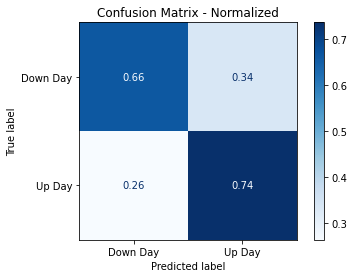

In [31]:
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

rf_matrix = confusion_matrix(y_test, y_pred)

true_negatives = rf_matrix[0][0]
false_negatives = rf_matrix[1][0]
true_positives = rf_matrix[1][1]
false_positives = rf_matrix[0][1]

accuracy = (true_negatives + true_positives) / (true_negatives + true_positives + false_negatives + false_positives)
percision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
specificity = true_negatives / (true_negatives + false_positives)

print('Accuracy: {}'.format(float(accuracy)))
print('Precision: {}'.format(float(percision)))
print('Recall: {}'.format(float(recall)))
print('Specificity: {}'.format(float(specificity)))
print()

disp = plot_confusion_matrix(classifier, X_test, y_test, display_labels = ['Down Day', 'Up Day'], normalize = 'true', cmap=plt.cm.Blues)
disp.ax_.set_title('Confusion Matrix - Normalized')
plt.show()

In [32]:
print("Model's Out-Of-Bag Error Score: {}".format(classifier.oob_score_))

Model's Out-Of-Bag Error Score: 0.6906283280085197


In [33]:
# Calculate feature importance and store in pandas series
feature_imp = pd.Series(classifier.feature_importances_, index=X_Cols.columns).sort_values(ascending=False)
feature_imp

r_percent               0.228043
k_percent               0.215373
RSI                     0.200796
MACD                    0.181267
Price_Rate_Of_Change    0.174521
dtype: float64

#### Visualising Feature Importance

Text(0.5, 1.0, 'Random Forest: Feature Importance Graph')

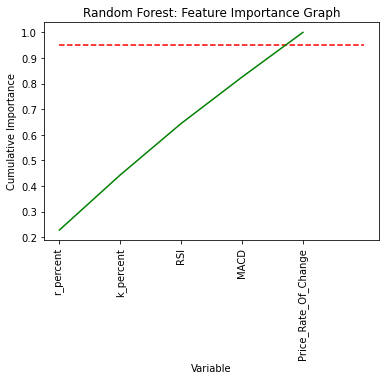

In [34]:
# store the values in a list to plot.
x_values = list(range(len(classifier.feature_importances_)))
cumulative_importances = np.cumsum(feature_imp.values)
# Make a line graph
plt.plot(x_values, cumulative_importances, 'g-')
# Draw line at 95% of importance retained
plt.hlines(y = 0.95, xmin = 0, xmax = len(feature_imp), color = 'r', linestyles = 'dashed')
# Format x ticks and labels
plt.xticks(x_values, feature_imp.index, rotation = 'vertical')
# Axis labels and title
plt.xlabel('Variable')
plt.ylabel('Cumulative Importance')
plt.title('Random Forest: Feature Importance Graph')

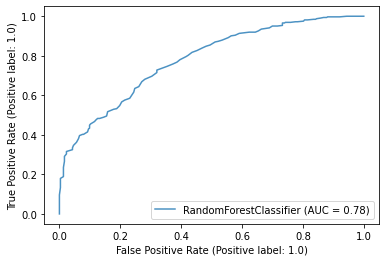

In [35]:
# Create an ROC Curve plot.
rfc_disp = plot_roc_curve(classifier, X_test, y_test, alpha = 0.8)
plt.show()

## **Stock Forecasting using Long Short Term Memory Networks (LSTM)**

**Importing Libraries**

In [36]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.models import load_model
from sklearn.metrics import mean_squared_error, r2_score
import math
import datetime as dt
from datetime import datetime
from matplotlib.pyplot import figure
from plotly import graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, iplot
init_notebook_mode(connected=True)

**Fetching Stock Data from Yahoo Finance**

In [37]:
#fetching the last 10 years data with interval of 1 day
stock_symbol = "AAPL"
data = yf.download(tickers=stock_symbol,period='10y',interval='1d')
data.reset_index(inplace = True) # resetting index

[*********************100%***********************]  1 of 1 completed


In [38]:
data.head() #displays the first 5 rows

,Date,Open,High,Low,Close,Adj Close,Volume
0,2011-12-05,14.053214,14.157500,13.942500,14.036071,12.034036,357210000
1,2011-12-06,14.018214,14.093929,13.906429,13.962500,11.970959,283598000
2,2011-12-07,13.926071,13.962143,13.812857,13.896071,11.914009,304746400
3,2011-12-08,13.980357,14.125000,13.936786,13.952143,11.962082,376356400
4,2011-12-09,14.030357,14.072857,13.965357,14.057857,12.052717,296993200


In [39]:
data.tail() #displays the last 5 rows

,Date,Open,High,Low,Close,Adj Close,Volume
2512,2021-11-29,159.369995,161.190002,158.789993,160.240005,160.240005,88748200
2513,2021-11-30,159.990005,165.520004,159.919998,165.300003,165.300003,174048100
2514,2021-12-01,167.479996,170.300003,164.529999,164.770004,164.770004,152052500
2515,2021-12-02,158.740005,164.199997,157.800003,163.759995,163.759995,136739200
2516,2021-12-03,164.020004,164.960007,159.720001,161.839996,161.839996,117938300


In [40]:
print("Dimensions of Dataset:",data.shape)

Dimensions of Dataset: (2517, 7)


### **Visualising the Stock Open and Close Price**

In [41]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=data['Date'],y=data['Open'],name='Stock Open Price'))
fig.add_trace(go.Scatter(x=data['Date'],y=data['Close'],name='Stock Close Price'))
fig.layout.update(title=stock_symbol+" Stock Open and Close Price in USD($)",xaxis_rangeslider_visible=True)
#fig #use this command when the notebook is connected to kernel (online)
iplot(fig) #use this commmand to display the plotly graph offline in HTML

**Generating Time Series Data on Stock Open Price Values**<br>
In case of Time Series data like stock opening prices (120,130,125,140,168) we can't use the ordinary train-test split like cross- validation or random seed. We have to use someother method.<br>
Training Data - (120,130,125) <br>
Test Data - (140,168) <br>
In time series data the next data is always dependent on the previous data, like Day 2 stock prices depends on Day 1 stock price and also Day 5 stock price depends on Day 1 to Day 4 stock prices

In [42]:
#fetching only the Stock Open Price Value as an numpy array
ds = data[["Open"]].values
ds[:10] #displays the first 10 open price values

array([[14.05321407],
       [14.01821423],
       [13.92607117],
       [13.98035717],
       [14.03035736],
       [13.98857117],
       [14.03571415],
       [13.81071377],
       [13.69035721],
       [13.58428574]])

**Scaling the Data**<br>
LSTM's are senstive to the scale of the data, hence we have to apply a Scaler to avoid picking up noise in the data

In [43]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1)) #all the values would be scaled/converted between 0 to 1
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))
ds_scaled[:10] #displays the first 10 scaled open price values

array([[0.00304705],
       [0.00281963],
       [0.00222089],
       [0.00257364],
       [0.00289853],
       [0.00262701],
       [0.00293334],
       [0.00147131],
       [0.00068924],
       [0.        ]])

Defining Test and Train Data Sizes

In [44]:
#70% of the data is considered for training
train_size = int(len(ds_scaled)*0.70) 
#so the rest 30% is used for testing
test_size = len(ds_scaled) - train_size
print("Training Size:",train_size)
print("Testing Size:",test_size)

Training Size: 1761
Testing Size: 756


Splitting Data into Training and Test Data

In [45]:
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),:1]

In [46]:
ds_train[:10] #displays first 10 training data observations

array([[0.00304705],
       [0.00281963],
       [0.00222089],
       [0.00257364],
       [0.00289853],
       [0.00262701],
       [0.00293334],
       [0.00147131],
       [0.00068924],
       [0.        ]])

In [47]:
ds_test[:10] #displays first 10 testing data observations

array([[0.20567964],
       [0.19075069],
       [0.19356105],
       [0.17976924],
       [0.19058826],
       [0.1885414 ],
       [0.18868762],
       [0.18626714],
       [0.18050025],
       [0.18038655]])

**Generating Time Series Data**<br>
Now after splitting the given data into Training and Testing Data we have to decide the timesteps i.e. if we want to compute the next day output how many previous days we have to consider.<br>
So basically we're converting the data into independent and dependent features based on the timesteps.<br>
Ex: <br>
1.   If Timesteps = 2, so let's take the training data (120,130,125)<br>So as the timesteps = 2, the 2 features will be f1=120 & f2=130 and the expected output should be 125 i.e. to predict next day we need to consider previous 2 days stock prices.
2.   Similarly If Timesteps = 3, so let's take the training data (120,130,125,140,134,150)<br>So as timesteps = 3, so there will be 3 features (IV's).<br>
It would like something like this:<br>
x_train &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; y_train<br>
f1 f2 f3 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;o/p<br>
120 130 125 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 140<br>
130 125 140 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 134<br>
We have to perform the same process for testing data

In [48]:
#if time_step=100 
#then at iteration 0 (i=0) 0,1,2,3.....99 elements in x_train and the 100th element in y_train
#then at iteration 1 (i=1) 1,2,3,4.....100 elements in x_train and the 101th element in y_train

#this function helps us to generate time series data from the given stock dataset
def create_ds(dataset,step):
    X, y = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        X.append(a)
        y.append(dataset[i + step, 0])
    return np.array(X), np.array(y)

In [49]:
#Taking 100 days price as one record for training
#we're taking the previous 100 days stock price to predict the next day
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [50]:
print("X_train:\n",X_train[0]) #displays the first training time series data
print("\ny_train:",y_train[0])

X_train:
 [0.00304705 0.00281963 0.00222089 0.00257364 0.00289853 0.00262701
 0.00293334 0.00147131 0.00068924 0.         0.00048967 0.0017173
 0.00378967 0.00386161 0.00448588 0.00527723 0.00615677 0.00534685
 0.00537237 0.00673926 0.00687849 0.00802724 0.00914581 0.01047556
 0.0105707  0.00982112 0.00972829 0.00912956 0.01017386 0.01081437
 0.01155467 0.01093737 0.0098188  0.01038273 0.0171916  0.01578063
 0.01484772 0.01516565 0.01745848 0.01811292 0.01753042 0.01785533
 0.01810595 0.01970026 0.02091862 0.02329964 0.02566674 0.02765555
 0.02884606 0.03107392 0.02579205 0.02848636 0.02936126 0.03080008
 0.03126421 0.03232941 0.03271    0.03425326 0.03740938 0.03894334
 0.03803132 0.03830516 0.03325536 0.03630473 0.03581507 0.03802436
 0.03913132 0.04111783 0.04587755 0.05088093 0.04742543 0.05059317
 0.05085773 0.0516073  0.05045624 0.05108515 0.0509227  0.05240562
 0.05523684 0.05393727 0.05300667 0.05139613 0.05730689 0.05662229
 0.05723264 0.05703538 0.06023792 0.05937231 0.056773

In [51]:
X_train.shape,y_train.shape
#1660 are records and 100 are the timesteps i.e. features (100 features are present as timestep =100)

((1660, 100), (1660,))

In [52]:
print("X_test:\n",X_test[0]) #displays the first test time series data
print("\ny_test:",y_test[0])

X_test:
 [0.20567964 0.19075069 0.19356105 0.17976924 0.19058826 0.1885414
 0.18868762 0.18626714 0.18050025 0.18038655 0.18139371 0.17229663
 0.166546   0.15239679 0.15264048 0.16488902 0.16758566 0.16925887
 0.16334578 0.14562273 0.1465162  0.15329026 0.15468731 0.15749765
 0.15946328 0.16008059 0.1567829  0.1558407  0.16040548 0.16222488
 0.16758566 0.16581499 0.16214365 0.16207869 0.16430421 0.16480779
 0.16555506 0.1769264  0.18157241 0.18295322 0.18368423 0.19253762
 0.19544543 0.19179035 0.18625091 0.18959733 0.18805408 0.19014964
 0.18742053 0.18992222 0.18742053 0.18982475 0.19081568 0.1904583
 0.19464945 0.19391844 0.1931062  0.19490937 0.19484438 0.1971349
 0.19754102 0.19547792 0.19417834 0.18841146 0.19681001 0.20413639
 0.20779146 0.21047184 0.21201511 0.21355836 0.21770078 0.21425687
 0.22041365 0.22905585 0.22283411 0.22307779 0.21835056 0.21867545
 0.220105   0.2230453  0.22215183 0.2256607  0.22816239 0.23085902
 0.23081029 0.23714577 0.2344816  0.23800674 0.23532634 

In [53]:
X_test.shape, y_test.shape
#655 are records and 100 are the timesteps i.e. features (100 features are present as timestep =100)

((655, 100), (655,))

**Reshaping the Training and Testing Data**<br>
There is a need to reshape the existing Training and Testing Data as the LSTM Model expects a 3-Dimensional Input.<br>
Those 3 Dimensions are:
1.   Samples (No of rows)
2.   Time-step
3. Features







In [54]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
#x_train.shape[0] is the 1660 records(samples) and x_train.shape[1] are the 100 timesteps
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
#x_test.shape[0] is the 655 records(samples) and x_test.shape[1] are the 100 timesteps

In [55]:
#checking the shape of training data after reshaping
X_train.shape,y_train.shape

((1660, 100, 1), (1660,))

In [56]:
#checking the shape of training data after reshaping
X_test.shape, y_test.shape

((655, 100, 1), (655,))

**Creating the Stacked LSTM Model**

In [57]:
#the Sequential model is a linear stack of layers, it helps us to stack the different Keras layers linearly
model = Sequential()
#adding 1st LSTM Layer (This is the Input Layer)
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
#return_sequences: Whether to return the last output in the output sequence, or the full sequence. Default: False.
#adding 2nd LSTM Layer (This is the first Hidden Layer)
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
#adding 3rd LSTM Layer (This is the second Hidden Layer)
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
#adding 4th LSTM Layer (This is the third Hidden Layer)
model.add(LSTM(units=50))
model.add(Dropout(0.2))
#adding the Dense Layer (This is the Output Layer)
model.add(Dense(units=1,activation='linear'))
#this dense layer gives output as it implements the operation: output = activation(dot(input, kernel) + bias) 
model.summary() #prints out a summary of the model

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100, 50)           10400     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout (Dropout)            (None, 100, 50)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0

In [58]:
#compiling the model with the above mentioned layers
model.compile(loss='mean_squared_error',optimizer='adam')

batch_size: The batch size defines the number of samples that will be propagated through the network.<br>
Ex: Let's say we have 1050 training samples and if we set the batch_size=100<br> The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network.

In [59]:
#fitting the model on the training data
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=150,batch_size=64)

Epoch 1/150
26/26 [==============================] - 5s 210ms/step - loss: 0.0026 - val_loss: 0.0080
Epoch 2/150
26/26 [==============================] - 4s 154ms/step - loss: 3.3184e-04 - val_loss: 0.0027
Epoch 3/150
26/26 [==============================] - 4s 163ms/step - loss: 2.9777e-04 - val_loss: 0.0034
Epoch 4/150
26/26 [==============================] - 5s 182ms/step - loss: 2.3055e-04 - val_loss: 0.0068
Epoch 5/150
26/26 [==============================] - 5s 181ms/step - loss: 2.2102e-04 - val_loss: 0.0066
Epoch 6/150
26/26 [==============================] - 5s 188ms/step - loss: 2.2489e-04 - val_loss: 0.0107
Epoch 7/150
26/26 [==============================] - 5s 176ms/step - loss: 1.9365e-04 - val_loss: 0.0091
Epoch 8/150
26/26 [==============================] - 5s 189ms/step - loss: 2.2985e-04 - val_loss: 0.0081
Epoch 9/150
26/26 [==============================] - 5s 203ms/step - loss: 2.0380e-04 - val_loss: 0.0105
Epoch 10/150
26/26 [==============================] - 6s 21

In [60]:
#saving the model for future predictions and forecasting
model.save('LSTM.h5')

Predicting on Training and Testing Data

In [61]:
train_predict = model.predict(X_train) #predict on training data
test_predict = model.predict(X_test) #predict on testing data

Visualising the Model's Training Data Predictions

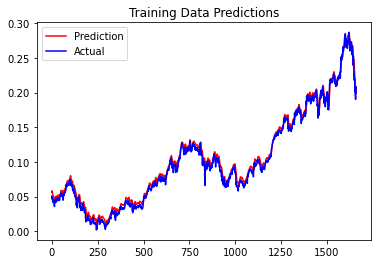

In [62]:
plt.plot(train_predict,color="red",label="Prediction")
plt.plot(y_train,color="blue",label="Actual")
plt.title("Training Data Predictions")
plt.legend()
plt.show()

Visualising the Model's Test Data Predictions

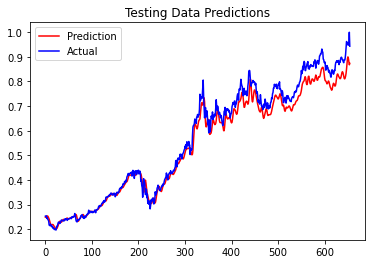

In [63]:
plt.plot(test_predict,color="red",label="Prediction")
plt.plot(y_test,color="blue",label="Actual")
plt.title("Testing Data Predictions")
plt.legend()
plt.show()

In [64]:
#performing Inverse transform to get the actual value, as it was scaled down
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

In [65]:
test_predict[:10] #displays the first 10 test data predictions

array([[51.76477 ],
       [51.66924 ],
       [51.920986],
       [52.40591 ],
       [52.619083],
       [52.49269 ],
       [52.02285 ],
       [51.358387],
       [50.6247  ],
       [49.612587]], dtype=float32)

Model Evaluation

Plotting the Model's Training Loss

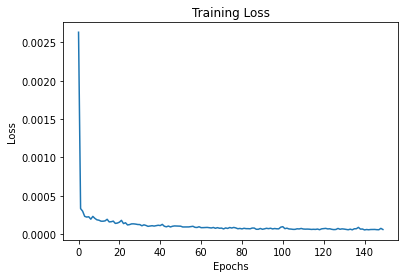

In [66]:
epochs = range(150)
plt.plot(epochs,history.history['loss'])
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.show()

Visualising the Model's Training & Test Predictions

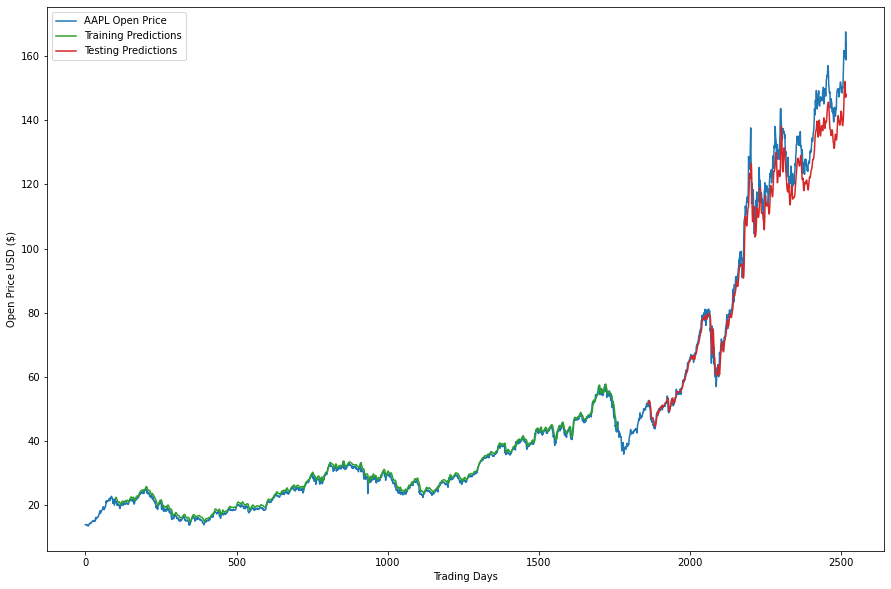

In [67]:
#shift train prediction for plotting
look_back=100 #timestep is 100
figure(figsize=(15, 10))
trainpred_plot = np.empty_like(ds)
trainpred_plot[:,:] = np.nan
trainpred_plot[look_back:len(train_predict)+look_back,:] = train_predict
#shift test prediction for plotting
testpred_plot = np.empty_like(ds)
testpred_plot[:,:] = np.nan
testpred_plot[len(train_predict)+(look_back*2)+1:len(ds)-1,:] = test_predict
#plot baseline and predictions
plt.plot(data[['Open']].values,color='tab:blue',label=stock_symbol+" Open Price")
plt.plot(trainpred_plot,color='tab:green',label="Training Predictions")
plt.plot(testpred_plot,color='tab:red',label="Testing Predictions")
plt.xlabel("Trading Days")
plt.ylabel("Open Price USD ($)")
plt.legend()
plt.show()

## **Forecasting Stock Open Price Value**

In [68]:
#data pre-processing
cols = list(data)[1:6]
dataset_train=data[cols]
training_set = dataset_train.values
training_set[:10]
#we're taking all the columns for forecasting the stock prices

array([[14.05321407, 14.15750027, 13.94250011, 14.03607082, 12.03403568],
       [14.01821423, 14.09392929, 13.90642929, 13.96249962, 11.97095871],
       [13.92607117, 13.96214294, 13.81285667, 13.89607143, 11.91400909],
       [13.98035717, 14.125     , 13.9367857 , 13.95214272, 11.96208191],
       [14.03035736, 14.0728569 , 13.96535683, 14.05785656, 12.05271721],
       [13.98857117, 14.06785679, 13.90892887, 13.99428558, 11.998209  ],
       [14.03571415, 14.12142944, 13.82499981, 13.88607121, 11.90543175],
       [13.81071377, 13.83500004, 13.48857117, 13.57821369, 11.64148617],
       [13.69035721, 13.70499992, 13.51107121, 13.53357124, 11.60321236],
       [13.58428574, 13.71964264, 13.55607128, 13.60785675, 11.66690159]])

In [69]:
#scaling the features
sc = StandardScaler()
training_set_scaled = sc.fit_transform(training_set)
sc_predict = StandardScaler()
sc_predict.fit_transform(training_set[:, 0:1])

array([[-0.90687602],
       [-0.90781646],
       [-0.91029233],
       ...,
       [ 3.21568075],
       [ 2.9808384 ],
       [ 3.12271125]])

In [70]:
#splitting data for training 
X_train = []
y_train = []
n_future = 30   # Number of days we want top predict into the future
n_past = 100     # Number of past days we want to use to predict the future
for i in range(n_past, len(training_set_scaled) - n_future +1):
  X_train.append(training_set_scaled[i - n_past:i, 0:dataset_train.shape[1] - 1])
  y_train.append(training_set_scaled[i + n_future - 1:i + n_future, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [71]:
#load the LSTM model that was saved before
model = load_model('LSTM.h5')

In [72]:
#writing future dates
from datetime import datetime
future_dates = pd.date_range(start = datetime.today(), periods = 30).to_pydatetime().tolist()
datelist_future = [timestamp.date() for timestamp in future_dates]
datelist_future = [ x.strftime('%Y-%m-%d') for x in datelist_future]
datelist_future[:5]

['2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08', '2021-12-09']

In [73]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

In [74]:
#forecasting
y_pred_future = sc_predict.inverse_transform(predictions_future)
PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=['Open']).set_index(pd.Series(datelist_future))
for_graph = PREDICTIONS_FUTURE.copy()
#we want only the next 7 days predictions 
PREDICTIONS_FUTURE = PREDICTIONS_FUTURE[1:8]
#calculating the average of next 7 days predictions
avg = PREDICTIONS_FUTURE['Open'].mean()


In [75]:
PREDICTIONS_FUTURE

,Open
2021-12-06,145.955154
2021-12-07,146.008682
2021-12-08,146.015289
2021-12-09,146.064331
2021-12-10,146.099167
2021-12-11,145.896759
2021-12-12,146.395157


In [76]:
print('Next 7 Days Average Stock Opening Price Value: '+str(round(avg,4)))

Next 7 Days Average Stock Opening Price Value: 146.0621


In [77]:
future = PREDICTIONS_FUTURE.copy()
future

,Open
2021-12-06,145.955154
2021-12-07,146.008682
2021-12-08,146.015289
2021-12-09,146.064331
2021-12-10,146.099167
2021-12-11,145.896759
2021-12-12,146.395157


**Visualising the next 7 days Stock Open Price Forecast**

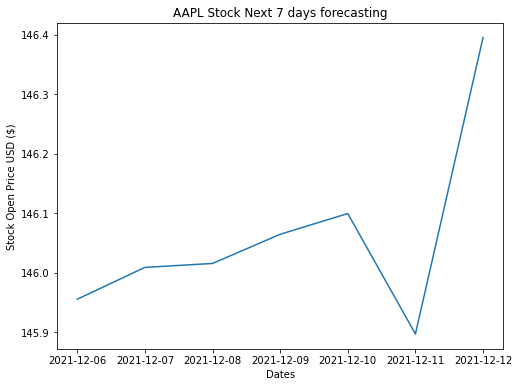

In [78]:
figure(figsize=(8, 6))
plt.plot(future['Open'])
plt.xlabel('Dates')
plt.ylabel('Stock Open Price USD ($)')
plt.title(stock_symbol+" Stock Next 7 days forecasting")
plt.show()

Pre-processing the Forecasting Pandas Dataframe for visualisation

In [79]:
for_graph = for_graph[:8] #selects only the first 7 rows
for_graph.reset_index(inplace = True) # resetting index
for_graph.rename(columns = {'index':'Date'}, inplace = True) #renaming the column
for_graph

,Date,Open
0,2021-12-05,145.920303
1,2021-12-06,145.955154
2,2021-12-07,146.008682
3,2021-12-08,146.015289
4,2021-12-09,146.064331
5,2021-12-10,146.099167
6,2021-12-11,145.896759
7,2021-12-12,146.395157


In [80]:
open = data[['Date','Open']] #creates a dataframe only with Stock's Date and Open columns

import datetime
#iterating through for_graph dataframe to convert date string to date time object
for i in range(len(for_graph)):
  date = for_graph['Date'][i]
  price = for_graph['Open'][i]
  date_time_str = date +' 00:00:00'
  date_time_obj = datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
  #adding the date time object to dataframe
  for_graph.loc[len(for_graph.index)] = [date_time_obj,price]

#removing the date strings
for_graph = for_graph[8:]
#restarting the index from 0
for_graph.index = pd.RangeIndex(len(for_graph.index))
for_graph.index = range(len(for_graph.index))

#adding the forecasted values to the actual open price
for i in range(len(for_graph)):
  date = for_graph['Date'][i]
  price = for_graph['Open'][i]
  open.loc[len(open.index)] = [date,price] 

C:\Users\Rahul\anaconda3\lib\site-packages\pandas\core\indexing.py:692: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [81]:
open.set_index("Date", inplace = True) #setting the Date column as index
open.tail(20) #contains both actual and predicted stock open prices

,Open
Date,
2021-11-17,151.000000
2021-11-18,153.710007
2021-11-19,157.649994
2021-11-22,161.679993
2021-11-23,161.119995
2021-11-24,160.750000
2021-11-26,159.570007
2021-11-29,159.369995
2021-11-30,159.990005


### **Visualising the Stacked LSTM Model Forecasting**

In [82]:
df = for_graph.copy()
df.set_index('Date',inplace=True)
fig1 = go.Figure()
fig1.add_trace(go.Scatter(x=open.index,y=open['Open'],name='Actual Open Price'))
fig1.add_trace(go.Scatter(x=df.index,y=df['Open'],name='Predicted Open Price'))
fig1.layout.update(title="Stacked LSTM Model Forecast on "+stock_symbol+" Stock Open Price USD($)",xaxis_rangeslider_visible=True)
#fig1 #use this command when the notebook is connected to kernel (online)
iplot(fig1) #use this commmand to display the plotly graph offline in HTML

### Model Evaluation

In [84]:
#root mean squre error
y_test = normalizer.inverse_transform(y_test.reshape(-1, 1))
rmse = np.sqrt(np.mean(((test_predict - y_test)**2)))
print("Root mean Squared Error (RMSE):"+str(round(rmse,3)))

#mean absolute percentage error
mape = np.mean(np.abs((y_test - test_predict)/y_test)) * 100
print("Mean Absolute Percentage Error (MAPE):"+str(round(mape,3)))

Root mean Squared Error (RMSE):5.905
Mean Absolute Percentage Error (MAPE):3.829
